In [2]:
import pandas as pd
import pandas.tseries.offsets as offsets

import numpy as np
import random
import datetime
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_absolute_error as mae 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time

import time
import pickle

import utils

import torch.optim as optim
import torch
import torch.nn as nn

In [3]:
def data_loader():
    train = pd.read_csv("JR/train.csv")
    test = pd.read_csv("JR/test.csv")
    info= pd.read_csv("JR/info.csv")

    network = pd.read_csv("JR/network.csv")
    return train, test, info, network

def preprocess(train, test, info, network):
    train_num = len(train)
    df = pd.concat([train, test])
    
    df["stop_and_direction"] = df["stopStation"] + df["directionCode"].astype(str)
    le = LabelEncoder()
    df["stop_and_direction"] = le.fit_transform(df["stop_and_direction"])
    
    
    le = LabelEncoder()
    df["stopStation"] = le.fit_transform(df.stopStation)
    #network["station1"] = le.transform(network.station1)
    #network["station2"] = le.transform(network.station2)
    
    le = LabelEncoder()
    df["trainNo"] = le.fit_transform(df.trainNo)
    
    le = LabelEncoder()
    df["lineName"] = le.fit_transform(df.lineName)
    info["lineName"] = le.transform(info.lineName)
    
    le = LabelEncoder()
    info["cse"] = le.fit_transform(info.cse)
    
    le = LabelEncoder()
    df["stop_and_direction"] = le.fit_transform(df.stop_and_direction)
    
    #print(df.head())
    #make daytime
    df["date_and_time"] = df.date.astype(str) + ":"+df.planArrival.astype(str)
    df["date_and_time"] = pd.to_datetime(df["date_and_time"], format='%Y%m%d:%H:%M')
    
    info["date_and_time"] = info.date.astype(str) + ":"+info.time.astype(str)
    info["date_and_time"] = pd.to_datetime(info["date_and_time"], format='%Y%m%d:%H:%M')
    df["cse"] = 23
    #print(df.head())
    #print(info.head())
    #return 0,0,0
    for i in range(len(info)):
        intime = info.date_and_time[i]
        intime = intime + datetime.timedelta(hours=2)
        df.loc[
            (info.date_and_time[i] <= df.date_and_time) &
            (intime > df.date_and_time) & 
            (df.date == info.date[i]) &
            #(info.cse[i] != 0) &
            (df.lineName == info.lineName[i]),"cse"] = info.cse[i]
        #print(sum(info.date_and_time[i] <= df.date_and_time))
        #print(sum(df.date == info.date[i]))
        #print(sum(df.lineName == info.lineName[i]))
        #print(sum( (info.date_and_time[i] <= df.date_and_time) &
        #    (df.date == info.date[i]) &
        #    (df.lineName == info.lineName[i])))
        #print(info.cse[i])
        #break
        #print(sum([(info.date_and_time[i] > df.date_and_time) &(df.date == info.date[i]) &(df.lineName == info.lineName[i])]))
    return df[:train_num], df[train_num:], info

train, test, info, network = data_loader()
train, test, info = preprocess(train, test, info, network)
print("finish")

finish


In [6]:
train["n_id"] = train.groupby(["trainNo","date","directionCode"]).ngroup()
train.n_id.value_counts()

29026    62
34464    45
60350    45
34084    45
24263    45
         ..
44755     1
12556     1
45340     1
44752     1
5175      1
Name: n_id, Length: 72573, dtype: int64

In [5]:
test["n_id"] = test.groupby(["trainNo","date","directionCode"]).ngroup()
test.n_id.value_counts()

26753    46
47206    45
44872    45
30140    45
29488    45
         ..
45134     1
50940     1
10976     1
48610     1
17228     1
Name: n_id, Length: 64526, dtype: int64

In [61]:
feature_cols = feature_cols = [
            #"date",
            #"MM", "DD",
    "cse",
    'lineName', 'directionCode', 'trainNo', 'stopStation',
     'stop_and_direction'
    ]

In [94]:
EMBEDDING_DIM = len(feature_cols)
HIDDEN_DIM = 128
target_size = 1

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.liner = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        out, _ = self.lstm(x.view(x.shape[0], 1, -1))
        out = self.liner(out.view(-1, self.hidden_dim))
        return out
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, target_size)

In [95]:
def ss(feature):
    return 0
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#scaler.fit(sample_data)

In [96]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

ids = train.n_id.unique()
random.shuffle(ids)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 10
loss_log = []
model = model.to(device)

cuda:2


In [100]:
loss_log = []
model.train()
for epoch in range(1, epochs + 1):
    print("\nepoch:", epoch)
    all_loss = 0
    for i, uid in enumerate(ids):
        t = torch.tensor(train[train.n_id == uid][feature_cols].values, dtype = torch.float)
        t = t.reshape(t.shape[0], 1, -1)
        label = torch.tensor(train[train.n_id == uid]["delayTime"].values, dtype = torch.float)

        t, label = t.to(device), label.to(device)
        output = model(t)
        #print(output)
        loss = criterion(output, label)
        #print("\r", i, "/", len(ids), end = "")
              #, " loss : ", loss.item(), end = "")
        print("\r", loss)

        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        all_loss += loss.item()
        if i == 1000:
            pass
        
    loss_log.append(all_loss/i)


epoch: 1
 tensor(0.1641, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1614, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1960, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1974, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2354, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2332, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.6429, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1053, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2444, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2528, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2577, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(3.7946, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1923, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2586, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2573, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2577,

 tensor(0.4437, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4452, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4578, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3764, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(7.3139, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3448, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4428, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.8057, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(7.9489, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(13.5868, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3627, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.0842, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3708, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4624, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4726, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.5038, device='

 tensor(0.4978, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7583, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4958, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4639, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(14.0952, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4925, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4940, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4913, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4579, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4814, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4894, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(66.9203, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.3644, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4543, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.5188, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4853, device=

 tensor(0.3042, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3025, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3008, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(10.2096, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2972, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1993, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1424, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2893, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2901, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2777, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1675, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2807, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.5956, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2813, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2735, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2754, device='

 tensor(0.0763, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0771, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0753, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0747, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.6652, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0783, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1696, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0704, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0694, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0683, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0750, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7395, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0648, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(6.4363, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0630, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0602, device='c

 tensor(0.0002, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0743, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0003, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(10.9843, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0267, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0004, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1253, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0374, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0007, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0008, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0008, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0009, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0011, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0012, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0013, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.4404, device='

 tensor(0.0527, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(3.1504, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.4230, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0976, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0486, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(7.6548, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0552, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0557, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(9.0775, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0579, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1233, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0587, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0491, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0854, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0580, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1137, device='c

 tensor(0.0955, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.2912, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1057, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.3092, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1093, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2648, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1124, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(15.7708, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1139, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(6.8932, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1142, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1153, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1161, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.6667, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1166, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1173, device='

 tensor(0.1038, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1068, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0988, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3956, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0915, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.5064, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.7797, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0899, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0856, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.5988, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.8809, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.8668, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.6515, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0849, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0826, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0790, device='c

 tensor(0.0648, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.5771, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0182, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0393, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(16.6501, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0789, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0180, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.8827, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0171, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0159, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0148, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0144, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0143, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(7.1323, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0133, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1998, device='

 tensor(0.0161, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0166, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0172, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(3.8938, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0201, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0189, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0199, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0199, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0209, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0429, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0339, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0223, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0231, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.3524, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0531, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0344, device='c

 tensor(0.1623, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1592, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(43.6178, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1671, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1679, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(6.1448, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1713, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1824, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1698, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(42.9580, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1761, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.7962, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1799, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1781, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1666, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1842, device=

 tensor(0.3370, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3823, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3828, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7059, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3852, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.7926, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3730, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(5.9920, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3889, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7026, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3925, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7073, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3965, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3978, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3698, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4007, device='c

 tensor(0.4930, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4723, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.7168, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2617, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4359, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4964, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(3.7376, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4282, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4954, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4958, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4959, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4972, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4850, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(3.1153, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4975, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4638, device='c

 tensor(0.3332, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3848, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3883, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3934, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4075, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(7.9482, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3484, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.4041, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3865, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3996, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3980, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.2860, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3917, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3937, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3817, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3802, device='c

 tensor(1.6481, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1673, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7396, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1640, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1605, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1617, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1597, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1588, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1573, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1737, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1539, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.7540, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.9037, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1475, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(2.9056, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1416, device='c

 tensor(0.0238, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0145, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0719, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.3905, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(4.3725, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0148, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0279, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0119, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(5.5989, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0110, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0106, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0102, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.1690, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(1.1615, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(8.8096, device='cuda:2', grad_fn=<SmoothL1LossBackward>)
 tensor(0.0088, device='c

KeyboardInterrupt: 

In [83]:
print(loss_log)

[1.2368991275506867, 1.4153015009141485, 2.2227688243712684, 1.6229943672644862, 1.890352784464054, 1.500422881662558, 1.5808717771493488, 1.4490027772646579, 1.7963371554665488, 2.7837522325050332]


In [81]:
print(loss_log)

[1.7299949956428937, 1.6407556017565148, 1.4002919603022819, 1.3081494040407842, 1.3036222129393444, 1.453350781287947, 1.691810446382835, 1.7408885372631484, 1.7545772710380951, 1.5805414213481426]


In [84]:
torch.save(model.state_dict(), "tmp_model.pth")


In [101]:
ids = test.n_id.unique()
model.eval()
for i, uid in enumerate(ids):
        t = torch.tensor(test[test.n_id == uid][feature_cols].values, dtype = torch.float)
        t = t.reshape(t.shape[0], 1, -1)
        label = torch.tensor(test[test.n_id == uid]["delayTime"].values, dtype = torch.float)

        t, label = t.to(device), label.to(device)
        output = model(t)
        print(output)
        if i == 5:
            break




tensor([[-0.0290],
        [-0.0224],
        [-0.1671],
        [-0.1669],
        [-0.1669]], device='cuda:2', grad_fn=<AddmmBackward>)
tensor([[-0.0703],
        [-0.1681],
        [-0.0635],
        [-0.2116],
        [-0.2124],
        [-0.1081]], device='cuda:2', grad_fn=<AddmmBackward>)
tensor([[-0.1747],
        [-0.0645],
        [-0.2118],
        [-0.0702],
        [-0.2125],
        [-0.0703],
        [-0.1082],
        [-0.2125],
        [-0.0703],
        [-0.0703],
        [-0.2125],
        [-0.0703],
        [-0.0703],
        [-0.0703],
        [-0.2125],
        [-0.2125],
        [-0.1082],
        [-0.0703],
        [-0.2125],
        [-0.2125],
        [-0.2125],
        [-0.2125],
        [-0.2125],
        [-0.2125],
        [-0.2125],
        [-0.1082],
        [-0.1082],
        [-0.2125],
        [-0.0703],
        [-0.2125],
        [-0.2125],
        [-0.1082]], device='cuda:2', grad_fn=<AddmmBackward>)
tensor([[-0.0324],
        [-0.2068],
        [-0.0695

In [5]:
train["mode"] = 0
test["mode"] = 1
df = pd.concat([train, test])
df["n_id"] = df.groupby(["trainNo", "date"]).ngroup()

In [6]:
df.n_id.value_counts()

54539     62
57031     46
95457     45
135121    45
47865     45
          ..
77664      1
102929     1
119985     1
116177     1
96069      1
Name: n_id, Length: 136820, dtype: int64

In [7]:
df[df["n_id"] == 96069].head(50)

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,stop_and_direction,date_and_time,cse,n_id,mode
1085257,2574142,20200902,3,2,2104,77,17:11,0.0,0.0,154,2020-09-02 17:11:00,23,96069,1


In [8]:
df[df.trainNo == 637].sort_values("date").head(30)

,id,date,lineName,directionCode,trainNo,stopStation,planArrival,delayTime,target,stop_and_direction,date_and_time,cse,n_id,mode
1094189,1094189,20200426,2,2,637,67,16:47,12.0,NaN,134,2020-04-26 16:47:00,17,29467,0


In [9]:
df.trainNo.value_counts()

2190    4142
598     4122
329     4104
1353    4027
1792    3906
        ... 
637        1
2244       1
73         1
2233       1
2269       1
Name: trainNo, Length: 2991, dtype: int64

In [14]:
import torch


In [11]:
t = torch.tensor(df[df.n_id == 54539][["stop_and_direction","stopStation"]].values, dtype = torch.float)

In [12]:
t.shape

torch.Size([62, 2])

In [15]:
feature = t.view(62,1,2)

In [16]:

EMBEDDING_DIM = 2
HIDDEN_DIM = 8
lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)


In [17]:
out1, out2 = lstm(feature)


In [46]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.liner = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        out, _ = self.lstm(x.view(x.shape[0], 1, -1))
        out = self.liner(out.view(-1, self.hidden_dim))
        return out
target_size = 1
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, target_size)

In [19]:
output = model(feature)

In [20]:
output.shape

torch.Size([62, 1])

In [21]:
label = df[df.n_id == 54539]["delayTime"].values

In [22]:
criterion = nn.SmoothL1Loss()

In [23]:
criterion(output, torch.tensor(label))

tensor(8.7243, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)

In [24]:
n_id = 54359
t = torch.tensor(df[df.n_id == n_id][["stop_and_direction","stopStation"]].values, dtype = torch.float)
t = t.reshape(t.shape[0], 1, -1)
label = torch.tensor(df[df.n_id == n_id]["delayTime"].values)

In [25]:
output = model(t)
criterion(output, torch.tensor(label))

tensor(0.0070, dtype=torch.float64, grad_fn=<SmoothL1LossBackward>)

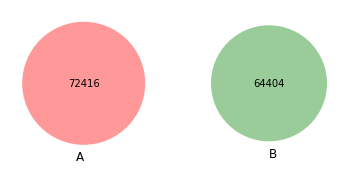

In [26]:
from matplotlib_venn import venn2
venn2([set(df[df["mode"] == 0].n_id.unique()), set(df[df["mode"] == 1].n_id.unique())])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(sample_data)

In [50]:


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

ids = train.n_id.unique()
random.shuffle(ids)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
epochs = 10
loss_log = []
model = model.to(device)
for i in range(1, epochs + 1):
    all_loss = 0
    for i, uid in enumerate(ids):
        t = torch.tensor(train[train.n_id == uid][["stop_and_direction","stopStation"]].values, dtype = torch.float)
        t = t.reshape(t.shape[0], 1, -1)
        label = torch.tensor(train[train.n_id == uid]["delayTime"].values, dtype = torch.float)

        t, label = t.to(device), label.to(device)
        output = model(t)
        #print(output)
        loss = criterion(output, label)
        print("\r", i, "/", len(ids), " loss : ", loss.item(), end = "")

        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        all_loss += loss.item()
    loss_log.append(all_loss)

cuda:2
 37161 / 72416  loss :  1.04812812805175784655loss :  0.0004731510707642883 72416  loss :  0.026221895590424538 loss :  2.77136850357055665129 / 72416  loss :  0.070121631026268 loss :  0.439518183469772344.6888575553894040.1233745068311691311320 / 72416  loss :  0.213111013174057/ 72416  loss :  0.032170236110687256 loss :  13.79572772979736372416  loss :  0.316155046224594115113 / 72416  loss :  4.4520902633666990.185216993093490617497 / 72416  loss :  0.018346225842833520.1228945478796958920172 / 72416  loss :  0.0443268716335296629786 / 72416  loss :  0.01504654344171285672416  loss :  0.272072464227676432131 / 72416  loss :  6.0427327156066895 loss :  2.0615081787109375  loss :  0.2021289467811584533707 / 72416  loss :  0.22176715731620789 0.40293040871620180.10154785215854645 0.22350624203681946/ 72416  loss :  1.402168989181518672416  loss :  0.16972453892230988/ 72416  loss :  0.2943851649761242349 / 72416  loss :  0.08384586870670319 loss :  0.23764556646347046 72416  l

KeyboardInterrupt: 

In [150]:
len(loss_log)

0